In [258]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import missingno as msno

from keras.layers import Input, Dense, concatenate, Embedding, LSTM
from keras.layers import Dropout, BatchNormalization
from keras.models import Model

import matplotlib.pyplot as plt
%matplotlib inline

In [222]:
df = pd.read_csv('job_skills.csv')
df.head(3)

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin..."
2,Google,"Data Analyst, Product and Tools Operations, Go...",Technical Solutions,"New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...


In [223]:
df.dropna(inplace=True)

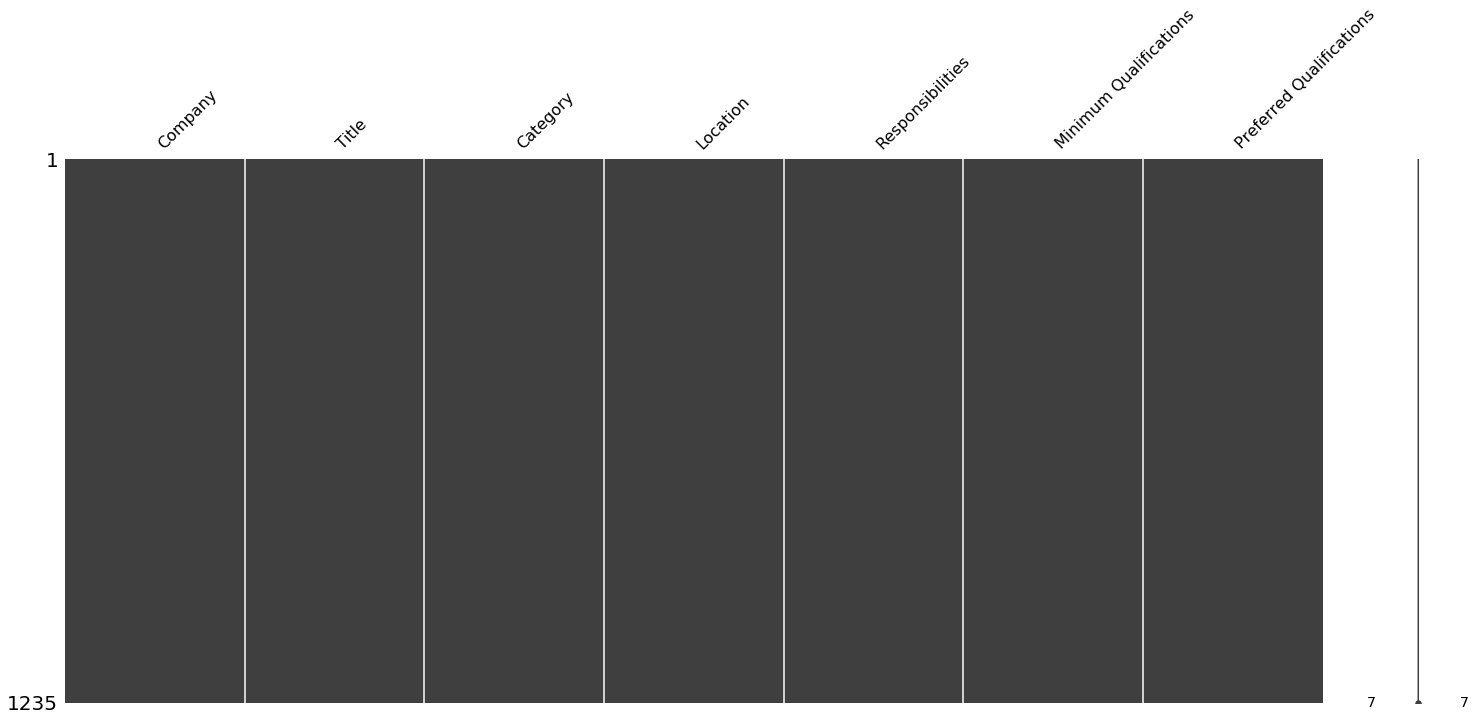

In [224]:
msno.matrix(df)

In [225]:
cnt = TfidfVectorizer(stop_words='english', lowercase=True, strip_accents='ascii')
lbl = LabelEncoder()

In [226]:
def combine(i):
    return ' '.join(df.iloc[i,-3:]).replace("\n","")

In [227]:
all_text = [combine(i) for i in range(df.shape[0])]
responsibilities = df['Responsibilities']
qualifications = df['Minimum Qualifications']
preferred = df['Preferred Qualifications']

In [228]:
category = df['Category']

In [229]:
full_txt = cnt.fit_transform(all_text)
len(cnt.vocabulary_)

5647

In [230]:
category_dims = len(np.unique(category))
category_dims

23

In [231]:
responsibilities = cnt.transform(responsibilities)
qualifications = cnt.transform(qualifications)
preferred = cnt.transform(preferred)

In [232]:
category = lbl.fit_transform(category)

# Functional model with Multi-inputs

In [252]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [244]:
t = Tokenizer(num_words=5000)

In [245]:
t.fit_on_texts(all_text)

(array([  2., 181., 372., 414., 172.,  49.,  42.,   2.,   0.,   1.]),
 array([ 20. ,  73.3, 126.6, 179.9, 233.2, 286.5, 339.8, 393.1, 446.4,
        499.7, 553. ]),
 <a list of 10 Patch objects>)

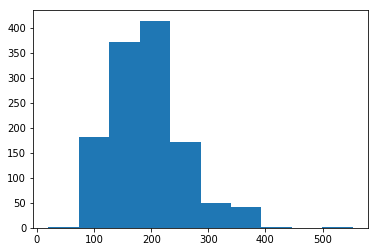

In [254]:
plt.hist([len(i) for i in seq])

In [255]:
seq = t.texts_to_sequences(all_text)
pad = pad_sequences(seq, maxlen=300, truncating='post', padding='post')

In [256]:
pad.shape

(1235, 300)

In [262]:
inp = Input((pad.shape[1],))
x = Embedding(5000, 128, input_length=pad.shape[1])(inp)
x = LSTM(64, return_sequences=True, activation='relu')(x)
x = LSTM(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(category_dims, activation='softmax')(x)

model = Model(inp, out)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        (None, 300)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 300, 128)          640000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 300, 64)           49408     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_57 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_58 (Dropout)         (None, 32)                0         
__________

In [263]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.fit(pad, category, 
          epochs=100, 
          batch_size=128, 
          validation_split=0.3, 
          verbose=1)

Train on 864 samples, validate on 371 samples
Epoch 1/100
864/864 [==============================] - 8s 10ms/step - loss: 3.1295 - acc: 0.0949 - val_loss: 3.1485 - val_acc: 0.0000e+00
Epoch 2/100
864/864 [==============================] - 5s 6ms/step - loss: 3.1102 - acc: 0.1539 - val_loss: 3.1746 - val_acc: 0.0000e+00
Epoch 3/100
864/864 [==============================] - 5s 6ms/step - loss: 3.0685 - acc: 0.1435 - val_loss: 3.2886 - val_acc: 0.0000e+00
Epoch 4/100
864/864 [==============================] - 5s 6ms/step - loss: 2.9724 - acc: 0.1412 - val_loss: 3.4669 - val_acc: 0.0000e+00
Epoch 5/100
864/864 [==============================] - 5s 6ms/step - loss: 2.9040 - acc: 0.1759 - val_loss: 3.8096 - val_acc: 0.0000e+00
Epoch 6/100
864/864 [==============================] - 6s 6ms/step - loss: 2.8678 - acc: 0.1597 - val_loss: 3.6259 - val_acc: 0.0000e+00
Epoch 7/100
864/864 [==============================] - 5s 6ms/step - loss: 3.0272 - acc: 0.1782 - val_loss: 3.6569 - val_acc: 0.000

864/864 [==============================] - 5s 6ms/step - loss: 2.4955 - acc: 0.1829 - val_loss: 4.7586 - val_acc: 0.0000e+00
Epoch 61/100
864/864 [==============================] - 5s 6ms/step - loss: 2.4985 - acc: 0.2095 - val_loss: 4.7757 - val_acc: 0.0000e+00
Epoch 62/100
864/864 [==============================] - 6s 7ms/step - loss: 2.5067 - acc: 0.1979 - val_loss: 4.8160 - val_acc: 0.0000e+00
Epoch 63/100
864/864 [==============================] - 5s 6ms/step - loss: 2.4696 - acc: 0.2060 - val_loss: 4.8892 - val_acc: 0.0000e+00
Epoch 64/100
864/864 [==============================] - 6s 6ms/step - loss: 2.5797 - acc: 0.2002 - val_loss: 4.9782 - val_acc: 0.0000e+00
Epoch 65/100
864/864 [==============================] - 5s 6ms/step - loss: 2.5593 - acc: 0.1968 - val_loss: 4.9226 - val_acc: 0.0000e+00
Epoch 66/100
864/864 [==============================] - 5s 6ms/step - loss: 2.5966 - acc: 0.2130 - val_loss: 5.0341 - val_acc: 0.0000e+00
Epoch 67/100
864/864 [=========================

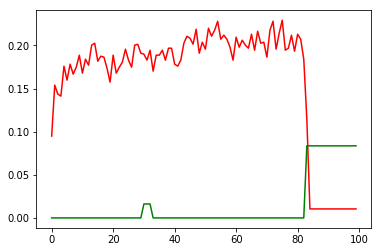

In [264]:
plt.plot(model.history.history.get('acc'),'r')
plt.plot(model.history.history.get('val_acc'),'g')

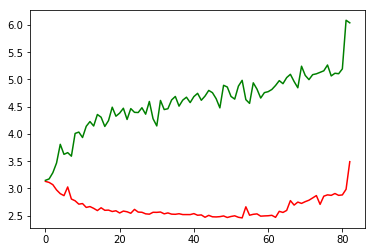

In [265]:
plt.plot(model.history.history.get('loss'),'r')
plt.plot(model.history.history.get('val_loss'),'g')